<a href="https://colab.research.google.com/github/makezazainw/Project/blob/main/Lab_Original_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **ติดตั้ง Kaggle เเละ เรียกใช้ไฟล์ json เพื่อติดต่อใช้ dataset ใน kaggle**

In [1]:
# Install Kaggle API
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 7.2MB/s 
     |████████████████████████████████| 5.3MB 24.2MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 133kB 50.6MB/s 
     |████████████████████████████████| 112kB 56.3MB/s 


In [2]:
# only for google colab
import os
os.environ['KAGGLE_USERNAME'] = "thammatattantipitham" 
os.environ['KAGGLE_KEY'] = "3cf826ab97707228fb1602519992740b"

In [3]:
!kaggle datasets download -d thammatattantipitham/originalthaiherb --unzip

 74% 11.0M/15.0M [00:00<00:00, 111MB/s]
100% 15.0M/15.0M [00:00<00:00, 95.8MB/s]


In [4]:
#สร้างไฟล์ folder ขึ้นมาเเละเพิ่มข้อมูลเข้าไปใน folder
!mkdir originalthaiherb
!mv  "train" "val" originalthaiherb

### **เริ่มต้นการ import library ต่างๆเเละการเรียกใช้ไฟล์**


In [5]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import keras

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.applications.vgg19 import VGG19
from tensorflow.python.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.applications import InceptionV3
sys.version

'3.6.9 (default, Oct  8 2020, 12:12:24) \n[GCC 8.4.0]'

In [6]:
from tensorflow.compat.v1.keras.backend import set_session

config = tf.compat.v1.ConfigProto()

config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

config.log_device_placement = True  # to log device placement (on which device the operation ran)

sess = tf.compat.v1.Session(config=config)

set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [7]:
DATASET_PATH  = 'originalthaiherb/'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = 10
BATCH_SIZE    = 32  # try reducing batch size or freeze more layers if your GPU runs out of memory
epochs    = 50

In [8]:
#ทำ aug มาเเล้ว
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [9]:
#set training data
train_generator = train_datagen.flow_from_directory(DATASET_PATH+ r"train/",
                                                    target_size = IMAGE_SIZE,
                                                    # batch_size = BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle = True,
                                                    subset='training')

Found 1600 images belonging to 10 classes.


In [10]:
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_generator = valid_datagen.flow_from_directory(DATASET_PATH+ r"val/",                                      
                                                    target_size = IMAGE_SIZE,
                                                    # batch_size = 1,
                                                    class_mode='categorical',
                                                    shuffle = True
                                                    )

Found 410 images belonging to 10 classes.


### **Model MobileNet**

In [25]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "training_MobNet/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=50)

#Create the model
base_MobNet = MobileNet(include_top=False,weights='imagenet',input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))

model_mobnet = Sequential()
model_mobnet.add(base_MobNet) 
model_mobnet.add(Flatten()) 
model_mobnet.add(Dense(512,activation=('relu'),input_dim=64))
model_mobnet.add(Dense(256,activation=('relu'))) 
model_mobnet.add(Dense(128,activation=('relu'))) 
#model_mobnet.add(Dropout(.3))
model_mobnet.add(Dense(64,activation=('relu')))
#model_mobnet.add(Dropout(.2))
model_mobnet.add(Dense(10,activation=('softmax')))

# Save the weights using the `checkpoint_path` format
model_mobnet.save_weights(checkpoint_path.format(epoch=0))

In [26]:
# Model Summary
base_MobNet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [27]:
model_mobnet.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               25690624  
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 10)               

In [ ]:
model_mobnet.compile(optimizer=Adam(lr=0.0001),  #Adam(lr=1e-5)
                  loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
start = time.time()

history = model_mobnet.fit_generator(
    generator=train_generator, 
    steps_per_epoch=train_generator.samples//BATCH_SIZE,   # -> 106 # images 3392 = steps * batch_size = 106 * 32 
    epochs=epochs, 
    validation_steps=valid_generator.samples//BATCH_SIZE, # -> 26 # images 832 = steps * batch_size = 26 * 32
    validation_data=valid_generator,
    callbacks = [cp_callback],
    verbose = 1
)

end = time.time()
duration = end - start
print ('\n model_mobnet took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

###**ขั้นตอนการ Save file Model เเละ Json**

In [ ]:
#เปลี่ยนชื่อไฟล์ทุกครั้งเวลา SAVE
model_mobnet.save('/content/drive/My Drive/Final Project/Dataset-Lab/Original/saved_model/model-mobnet(lastest).h5') #ดูจำนวนรอบที่เทรนด้วยว่าทั้งหมดกี่รอบจริงๆเเล้ว
model_mobnet.save_weights('/content/drive/My Drive/Final Project/Dataset-Lab/Original/saved_model/weightmodel-mobnet.h5')

In [ ]:
#Import dependencies
!mkdir jsonfile
import json
from keras.models import model_from_json, load_model
with open('jsonfile/model_mobnet.json', 'w') as f:
    f.write(model_mobnet.to_json())
print("Saved model success")

###**เเสดงกราฟข้อมูลค่าความเเม่นยำเเละค่าความสูญเสีย Training เเละ Validation**

In [ ]:
import matplotlib.pyplot as plt

acc = model_mobnet.history.history['accuracy']
val_acc = model_mobnet.history.history['val_accuracy']

loss= model_mobnet.history.history['loss']
val_loss= model_mobnet.history.history['val_loss']


plt.style.use("ggplot")
#  "Accuracy"
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
#  "Loss"
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

###**จุด Checkpoint**

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

In [ ]:
# Load the previously saved weights
model_mobnet.load_weights(latest)

# Re-evaluate the model
loss, acc = model_mobnet.evaluate(valid_generator, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

###**Save model อีกเเบบเพื่อนำไปเเปลงเป็น TensorflwLite**

In [ ]:
# Save the entire model as a SavedModel.
model_mobnet.save('saved_model/my_model') 

In [ ]:
model= tf.keras.models.load_model('saved_model/my_model')
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tflite_converter.convert()
open("tf_lite_model(200epochsmobnet).tflite", "wb").write(tflite_model) 

###**ขั้นตอนของ Prediction เเบบบ Confusion Matrix**

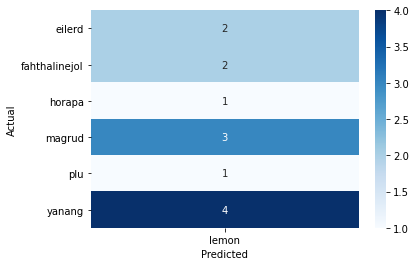

test accuracy : 15.384615384615385


In [ ]:
import seaborn as sn
import pandas as pd

model = tf.keras.models.load_model('/content/drive/MyDrive/Final Project/Dataset-Nature/Original/saved_model/model-resnet50(200epochs).h5')
filenames = valid_generator.filenames
nb_samples = len(valid_generator)
y_prob=[]
y_act=[]
valid_generator.reset()
for _ in range(nb_samples):
    x_test, y_test = valid_generator.next()
    y_prob.append(model.predict(x_test))
    y_act.append(y_test)


predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class', 'actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, cmap='Blues', annot= True, fmt='d')
plt.show()
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))